In [1]:
from keras.datasets import fashion_mnist

In [2]:
import numpy as np
import matplotlib.pyplot as plt # data visualization
import copy
import math

In [3]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
class_names=['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:
x_train = x_train.reshape(60000, 784)/256
x_test = x_test.reshape(10000, 784)/256
print("train_data_size:",x_train.shape)
print("test_data_size:",x_test.shape)

train_data_size: (60000, 784)
test_data_size: (10000, 784)


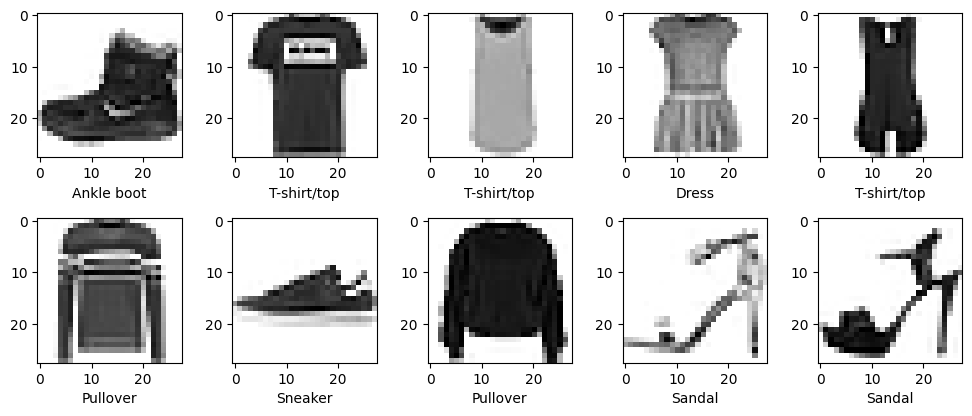

In [12]:
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.grid(False)
    plt.imshow(x_train[i].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
    plt.tight_layout()
plt.show()

In [ ]:
# logistic function.
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# relu function.
def relu(x):
    return np.maximum(0, x)

# derivative of relu
def d_relu(x):
    if x > 0:
      return 1
    elif x <= 0:
      return 0

# derivate of logistic function
def d_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

# derivative of tanh function.
def d_tanh(x):
    return 1 - np.square(np.tanh(x))

# activation function : sigmoid, tanh, relu
def g(ai, hiddennodes, activation_func):
    if activation_func == "sigmoid":
        hi = np.empty([hiddennodes, 1])
        for i in range(hiddennodes):
            hi[i] = sigmoid(ai[i])
        return hi
    elif activation_func == "tanh":
        hi = np.empty([hiddennodes, 1])
        for i in range(hiddennodes):
            hi[i] = np.tanh(ai[i])
        return hi
    elif activation_func == "relu":
      hi = np.empty([hiddennodes, 1])
      for i in range(hiddennodes):
            hi[i] = relu(ai[i])
      return hi

# Derivate of the activation function :sigmoid, tanh, relu
def g1(ai, hiddennodes, activation_func):
    if activation_func == "sigmoid":
        hi = np.empty([hiddennodes, 1])
        for i in range(hiddennodes):
            hi[i] = d_sigmoid(ai[i])
        return hi
    elif activation_func == "tanh":
        hi = np.empty([hiddennodes, 1])
        for i in range(hiddennodes):
            hi[i] = d_tanh(ai[i])
        return hi
    elif activation_func == "relu":
        hi = np.empty([hiddennodes, 1])
        for i in range(hiddennodes):
            hi[i] = d_relu(ai[i])
        return hi

# Output function
def o(al, outputnode):
    output = np.empty([outputnode, 1])
    s = 0
    for i in range(outputnode):
        s += np.exp(al[i])
    for i in range(outputnode):
        output[i] = np.exp(al[i]) / s
    return output

# Initialization of W's and b's.
def init(W, b, inputnode, hiddenlayers, hiddennodes, outputnode, initializer):
    if initializer == "random":
          W[1] = (np.random.rand(hiddennodes, inputnode) - 0.5)
          for i in range(2,hiddenlayers):
            W[i] = (np.random.rand(hiddennodes, hiddennodes) - 0.5)
          for i in range(1,hiddenlayers):
            b[i] = np.zeros([hiddennodes, 1])

          W[hiddenlayers] = (np.random.rand(outputnode, hiddennodes) - 0.5)
          b[hiddenlayers] = np.zeros([outputnode, 1])
    return W, b

# forward propogation  Returns the final probability distribution for each of the label.
def forward_propagation(x_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, L, activation_func):
    h[0] = x_train[L].reshape(-1, 1)
    for i in range(1, hiddenlayers):
        a[i] = np.dot(W[i], h[i-1]) + b[i]
        h[i] = g(a[i], hiddennodes, activation_func)
    a[hiddenlayers] = np.dot(W[hiddenlayers], h[hiddenlayers-1]) + b[hiddenlayers]
    yhat = o(a[hiddenlayers], outputnode)
    return yhat

# One hot vector
def e(l, len):
    y = np.zeros([len, 1])
    y[l] = 1
    return y

# back propogation. Compute partial derivatives of Loss function w.r.t output units, hidden units and input unit
def back_prop(y_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, VW, Vb, L, yhat, activation_func, loss_func):
    Va = {}
    Vh = {}
    Val = np.empty([outputnode,1])
    if loss_func == "cross_entropy":
        Val = yhat - e(y_train[L], outputnode)
    elif loss_func == "squared_error":
        for i in range(outputnode):
            Val[i] = np.dot(np.transpose(np.multiply(yhat, yhat - e(y_train[L], outputnode))), e(i, outputnode) - np.ones([outputnode,1]) * yhat[i])
    Va[hiddenlayers] = Val
    for k in range(hiddenlayers, 0, -1):
        if k in VW.keys():
            VW[k] += np.dot(Va[k],np.transpose(h[k-1]))
            Vb[k] += Va[k]
        else:
            VW[k] = np.dot(Va[k],np.transpose(h[k-1]))
            Vb[k] = Va[k]
        Vh[k-1] = np.dot(np.transpose(W[k]), Va[k])
        if k != 1:
            Va[k-1] = np.multiply(Vh[k-1], g1(a[k-1], hiddennodes, activation_func).reshape(-1, 1))
    return VW, Vb

# loss function : squared error loss, cross entropy
def loss(yhat, y_train, loss_func, L, outputnode):
    if loss_func == "cross_entropy":
        return -np.log(yhat[y_train[L]])
    elif loss_func == "squared_error":
        return np.square(yhat - e(y_train[L], outputnode))

# validation accuracy and the test accuracy for the trained Ws and bs
def accuracy(x_test, y_test, x_train, y_train, W, b, hiddenlayers, outputnode, hiddennodes, activation_func):
    acc = 0
    y_pred = np.zeros(y_test.shape)
    for L in range(10000):
        a = {}
        h = {}
        h[0] = x_test[L].reshape(-1, 1)
        for i in range(1, hiddenlayers):
            a[i] = np.dot(W[i], h[i-1]) + b[i]
            h[i] = g(a[i], hiddennodes, activation_func)
        a[hiddenlayers] = np.dot(W[hiddenlayers], h[hiddenlayers-1]) + b[hiddenlayers]
        yhat = o(a[hiddenlayers], outputnode)
        index = 0
        val = 0
        for i in range(np.shape(yhat)[0]):
            if val < yhat[i]:
                index = i
                val = yhat[i]
        y_pred[L] = index
        acc += int(index == y_test[L])
    # Print progress
    val_acc = 0
    total_val_loss = 0
    for L in range(54000, 60000):
        a = {}
        h = {}
        yhat = forward_propagation(x_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, L, activation_func)
        val_loss = loss(yhat, y_train, loss_func, L, outputnode)
        total_val_loss += val_loss
        index = 0
        val = 0
        for i in range(np.shape(yhat)[0]):
            if val < yhat[i]:
                index = i
                val = yhat[i]
        val_acc += int(index == y_train[L])
    print("test accuracy is ", acc/100,"%", "validation acc is ", val_acc/60, "%")

# stochastic gradient descent
def sgd(x_train, y_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, learning_rate, num_epochs, batch_size, train_set, activation_func, loss_func):
          for inp in range(num_epochs):
            VW = {}
            Vb = {}
            tot_loss = 0
            for L in range(train_set):
                yhat = forward_propagation(x_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, L, activation_func)
                curr_loss = loss(yhat, y_train, loss_func, L, outputnode)
                tot_loss += curr_loss
                back_prop(y_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, VW, Vb, L, yhat, activation_func, loss_func)
                if L % batch_size == 0:
                    for i in range(1, hiddenlayers+1):
                        W[i] -= learning_rate * VW[i]

                    for i in range(1, hiddenlayers):
                        b[i] -= learning_rate * Vb[i]
                    VW = {}
                    Vb = {}
            accuracy(x_test, y_test, x_train, y_train, W, b, hiddenlayers, outputnode, hiddennodes, activation_func)

# momentum based gradient descent
def mbgd(x_train, y_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, learning_rate, num_epochs, batch_size, train_set, activation_func, loss_func):
        prev_w = copy.deepcopy(W)
        prev_b = copy.deepcopy(b)
        gamma  = 0.9
        for inp in range(num_epochs):
            VW = {}
            Vb = {}
            tot_loss = 0
            for L in range(train_set):
                yhat = forward_propagation(x_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, L, activation_func)
                curr_loss = loss(yhat, y_train, loss_func, L, outputnode)
                tot_loss += curr_loss
                back_prop(y_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, VW, Vb, L, yhat, activation_func, loss_func)
                if L % batch_size == 0:
                    for i in range(1, hiddenlayers+1):
                        v_W = gamma * prev_w[i] * int(inp != 0) + learning_rate * VW[i]
                        W[i] -= v_W
                        prev_w[i] =  copy.deepcopy(v_W)
                    for i in range(1, hiddenlayers):
                        v_b = gamma * prev_b[i] * int(inp != 0) + learning_rate * Vb[i]
                        b[i] -= v_b
                        prev_b[i] =  copy.deepcopy(v_b)
                    VW = {}
                    Vb = {}
            accuracy(x_test, y_test, x_train, y_train, W, b, hiddenlayers, outputnode, hiddennodes, activation_func)


# Root Mean Squared Propagation
def rmsprop(x_train, y_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, learning_rate, num_epochs, batch_size, train_set, activation_func, loss_func):
        beta = 0.1
        eps = 1e-8
        beta1 = 0.9
        v_W = {}
        v_b = {}
        for inp in range(num_epochs):
            VW = {}
            Vb = {}
            tot_loss = 0
            for L in range(train_set):
                yhat = forward_propagation(x_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, L, activation_func)
                curr_loss = loss(yhat, y_train, loss_func, L, outputnode)
                tot_loss += curr_loss
                back_prop(y_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, VW, Vb, L, yhat, activation_func, loss_func)
                if L % batch_size == 0:
                    for i in range(1, hiddenlayers+1):
                        if(inp==0):
                            v_W[i] = np.zeros(VW[i].shape, dtype=float)
                            v_b[i] = np.zeros(Vb[i].shape, dtype=float)

                    for i in range(1, hiddenlayers+1):
                        v_W[i] = beta1 * v_W[i] + (1 - beta) * np.square(VW[i])
                        W[i] -= (learning_rate / np.sqrt(v_W[i] + eps)) * VW[i]

                    for i in range(1, hiddenlayers):
                        v_b[i] = beta1 * v_b[i] + (1 - beta) * np.square(Vb[i])
                        b[i] -= (learning_rate / np.sqrt(v_b[i] + eps)) * Vb[i]
                    VW = {}
                    Vb = {}
            accuracy(x_test, y_test, x_train, y_train, W, b, hiddenlayers, outputnode, hiddennodes, activation_func)

# Adaptive Movement Estimation
def adam(x_train, y_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, learning_rate, num_epochs, batch_size, train_set, activation_func, loss_func):
        m_W={}
        v_W={}
        m_b={}
        v_b={}
        eps  = 1e-8
        beta1  =  0.9
        beta2 =  0.999
        for inp in range(num_epochs):
            VW = {}
            Vb = {}
            tot_loss = 0
            for L in range(train_set):
                yhat = forward_propagation(x_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, L, activation_func)
                curr_loss = loss(yhat, y_train, loss_func, L, outputnode)
                tot_loss += curr_loss
                back_prop(y_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, VW, Vb, L, yhat, activation_func, loss_func)
                if L % batch_size == 0:
                    for i in range(1, hiddenlayers+1):
                        if(inp == 0):
                            m_W[i] = np.zeros(VW[i].shape, dtype=float)
                            v_W[i] = np.zeros(VW[i].shape, dtype=float)
                            m_b[i] = np.zeros(Vb[i].shape, dtype=float)
                            v_b[i] = np.zeros(Vb[i].shape, dtype=float)
                    for i in range(1, hiddenlayers+1):
                        m_W[i] = beta1 * m_W[i] + (1 - beta1) * VW[i]
                        m_W_cap = m_W[i] / (1 - math.pow(beta1, (L / batch_size) + 1))
                        v_W[i] = beta2 * v_W[i] + (1 - beta2) * np.square(VW[i])
                        v_W_cap = v_W[i] / (1 - math.pow(beta2, (L / batch_size) + 1))
                        W[i] -= (learning_rate / np.sqrt(v_W_cap + eps)) * m_W_cap

                    for i in range(1, hiddenlayers):
                        m_b[i] = beta1 * m_b[i] + (1 - beta1) * Vb[i]
                        m_b_cap = m_b[i] / (1-math.pow(beta1,(L / batch_size) + 1))
                        v_b[i] = beta2 * v_b[i] +(1 - beta2) * np.square(Vb[i])
                        v_b_cap = v_b[i] / (1-math.pow(beta2, (L / batch_size) + 1))
                        b[i] -= (learning_rate / np.sqrt(v_b_cap + eps)) * m_b_cap
                    VW = {}
                    Vb = {}
            accuracy(x_test, y_test, x_train, y_train, W, b, hiddenlayers, outputnode, hiddennodes, activation_func)



# complete training of the dataset
def train(x_train, y_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, learning_rate, num_epochs, batch_size, opt, train_set, activation_func, loss_func, initializer):
    init(W, b,inputnode, hiddenlayers, hiddennodes, outputnode, initializer)
    if opt == "sgd":
        sgd(x_train, y_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, learning_rate, num_epochs, batch_size, train_set, activation_func, loss_func)
    elif opt == "mbgd":
        mbgd(x_train, y_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, learning_rate, num_epochs, batch_size, train_set, activation_func, loss_func)
    elif opt == "rmsprop":
        rmsprop(x_train, y_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, learning_rate, num_epochs, batch_size, train_set, activation_func, loss_func)
    elif opt == "adam":
        adam(x_train, y_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h, learning_rate, num_epochs, batch_size, train_set, activation_func, loss_func)

import itertools
import matplotlib.pyplot as plt

# Define the sweep configuration
sweep_config = {
    'name': "Punit Bhavsar",
    'parameters': {
        'hiddenlayers': [3, 5],
        'num_epochs': [10, 15],
        'hiddennodes': [32, 64],
        'learning_rate': [1e-2, 5e-3, 1e-3],
        'initializer': ["random"],
        'batch_size': [32, 64],
        'opt': ["sgd", "mbgd", "rmsprop", "adam"],
        'activation_func': ["sigmoid", "relu", "tanh"]
    }
}

# Initialize nodes and training set
outputnode = 10
inputnode = 784
train_set = 54000

W = {}
b = {}
a = {}
h = {}
loss_func = "cross_entropy"



# Define the training execution function
def execute(hiddenlayers, hiddennodes, learning_rate, initializer, batch_size, opt, activation_func, num_epochs):

    # Call the train function
    train(x_train, y_train, hiddenlayers, hiddennodes, inputnode, outputnode, W, b, a, h,
          learning_rate, num_epochs, batch_size, opt, train_set, activation_func, loss_func, initializer)


# Execute the sweep manually
param_grid = itertools.product(
    sweep_config['parameters']['hiddenlayers'],
    sweep_config['parameters']['hiddennodes'],
    sweep_config['parameters']['learning_rate'],
    sweep_config['parameters']['initializer'],
    sweep_config['parameters']['batch_size'],
    sweep_config['parameters']['opt'],
    sweep_config['parameters']['activation_func'],
    sweep_config['parameters']['num_epochs']
)
# Print progress

# Loop through each combination of parameters
for params in param_grid:
    print(params)
    execute(*params)



(3, 32, 0.01, 'random', 32, 'sgd', 'sigmoid', 10)
